# base_rbt

> Base functions and classes we use for our hacking on BT / RBT and related ideas

## Install

```sh
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'
```

## How to use

After installing, import like this:

In [ ]:
from base_rbt.base_model import *
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

We also need some other libraries:


In [ ]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

Now we give an end to end example. There are only a couple of steps. We first we need a dls i.e. a dataloader; then patch in our own definition of a loss funtion `lf`. Then it is a simple matter of defining an augmentation pipeline and fitting the model. We go through each of these now.
First, get some data:

In [ ]:
#Get some MNIST data and plonk it into a dls
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items = items.shuffle()
items = items[0:10]
split = RandomSplitter(valid_pct=0.0)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items))
dls = tds.dataloaders(bs=5,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)

Next we need to construct the `lf`. Here is a (silly!) modification to the BT loss function. We are just scaling the bt loss function by $0.01$. However, this illustrates the general API if we want to modify the loss function:

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return 0.01*lf_bt(pred, self.I,self.lmb)

Now we patch in our own definition of a loss function, using the tools from `base_lf`.  First define it:

In [ ]:
def lf_rbt(pred,seed,I,lmb):
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=10,indep=False,mask=True)
    cdiff_2 = CdiffSup(z1norm,z2norm) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=10,indep=True)
    cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

    cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2 #convex combination of rand and sup terms.

    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

This loss function has both a `random` component and a `sup` component.
Next patch it in:

In [ ]:
# #Using RBT
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt(pred,seed=self.seed,I=self.I,lmb=self.lmb)

We now need an augmentation pipeline. Let's also take a look at what it looks like. 

In [ ]:
n_in=1
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=1)

#model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)


aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,
                    rotate=False,jitter=False,bw=False,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3), rotate_deg=45,blur_s=11,s1=3,sol_t=0.05,sol_a=0.05, #hps of augs
                    flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,
                    rotate=False,jitter=False,bw=False,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3), rotate_deg=45,blur_s=11,s1=3,sol_t=0.05,sol_a=0.05, #hps of augs
                    flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines = [aug_pipelines_1,aug_pipelines_1]
tem = BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[tem])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 's1': 3, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 's1': 3, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


Finally,let's train RBT; We construct an encoder and a learner, then fit it. 

In [ ]:
#Full usage of above
ps=500 #projection size
hs=ps #hidden size in mlp at the end; typically just = ps. 
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=1) #create the encoder
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)#plonk the projector on the end of the encoder
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=1, print_augs=False)]) #build the learner
learn.fit(1) #train model, i.e. weights of encoder and projector.

epoch,train_loss,valid_loss,time
0,2890.274658,None,00:01


Once we have trained the `fastai_encoder` can evaluate in various ways. e.g. linear evaluation. 

**Ok now let's do an end to end CIFAR10 example. Let's comment a little more on the API as we go - this will be helpful when considering how to add functionality to (in particular) base_model**

Here are the steps at a high level:
- Define hps (e.g. batch size, projector dimension etc). Note that if the model changes then there may be different hps
- Get the data (train, tune, test) -> dls,dls_val, dls_test
- Patch in loss function definition
- Setup/define augmentations, encoder, model, learner
- Train BT/RBT (i.e. fit the learner
- Train linear classifier and record performance

Step 1): We need the data, and to set all the hps. 

In [ ]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=42
n_in=3
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=32
ps=100
seed=42 
bs=64 #for training BT
bs_val=128 #for training linear head
bs_test=256 #for evaluating linear head
ts=bs*2#00
ts_val=bs_val*5
ts_test=5*bs_test

In [ ]:
#data: dls, dls_val, dls_test
#get the data: Need dls, dls_val, dls_test
path = untar_data(URLs.CIFAR)
fnames = get_image_files(path / "train")
fnames.sort()
#shuffle data (in reproducible way)
seed_everything(seed=seed)
fnames = fnames.shuffle()

#fnames for train, eval and test
fnames_train = fnames[0:ts]
fnames_val = fnames[ts:ts+ts_val]
fnames_test = fnames[ts+ts_val:ts+ts_val+ts_test]

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

#labels for train,eval and test
labels = [label_func(fname) for fname in fnames]
labels_train = labels[0:ts]
labels_val = labels[ts:ts+ts_val]
labels_test = labels[ts+ts_val:ts+ts_val+ts_test]

#Used for training encoder i.e. BT
dls = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,seed=seed)
#Used for training linear classifier
dls_val = ImageDataLoaders.from_lists(path, fnames_val, labels_val,bs=bs_val, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,seed=seed)

#Used for evaluating linear classifier
dls_test = ImageDataLoaders.from_lists(path, fnames_test, labels_test,bs=bs_val, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,seed=seed)


set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

Step 2): Patch in definition of loss function, and also `after_epoch` (where we train linear classifier)

In [ ]:
# #Using BT
# @patch
# def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred, self.I,self.lmb)

Patch in `before_epoch` callback - perform linear evaluation every 200th epoch (say):

In [ ]:
aug_pipelines_val=[get_linear_batch_augs(size=size,stats=cifar_stats,resize=True,resize_scale=(0.3, 1.0))]
main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=1,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                    dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                    stats=cifar_stats,
                    aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                    encoder=None#encoder
                                )

In [ ]:
@patch
def after_epoch(self:BarlowTwins):
    #Put in eval mode and turn gradients off
    self.learn.eval()
    grad_on(self.learn.model,on=False)
    
    #Test in eval mode
    test_eq(self.learn.model.training,False)
    #Test gradients off
    test_grad_off(self.learn.model)

    ##
    main_linear_eval.encoder = self.learn.model.encoder #Update the encoder 
    main_linear_eval.model = LinearModel(encoder=main_linear_eval.encoder,indim=indim) #update the model (frozen encoder + head)
    acc = main_linear_eval() #train linear head on frozen encoder and get accuracy on test set
    self.acc_dict[self.epoch]=acc #update the acc_dict
    ##
    
    #Put in train mode and turn gradients back on
    self.learn.train()
    grad_on(self.learn.model,on=True)

    #Test training mode on
    test_eq(self.learn.model.training,True)
    #Test gradients on
    test_grad_on(self.learn.model)
    


Step 3): Define encoder and model; Define augmentation pipelines; Define learner.  

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

#If we are using a different model, this call will just look like `create_rat_model(...)`
model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
test(model.training,True,cmp=operator.eq,cname='model not in training mode')

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                                                 bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                 resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
                                                 bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.5,sol_p=0.0,
                                                 stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                 )

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                                                 bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                 resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
                                                 bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.1,sol_p=0.2,
                                                 stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                 )

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#If we are using a different `callback` to `BarlowTwins` then we can simply replace `BarlowTwins` with 
#e.g. `BarlowTriplets`. We can define in base_model and just import with no issues. 
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])

Step 3): (Optional): View the augmentations:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 5, 's1': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 5, 's1': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

  

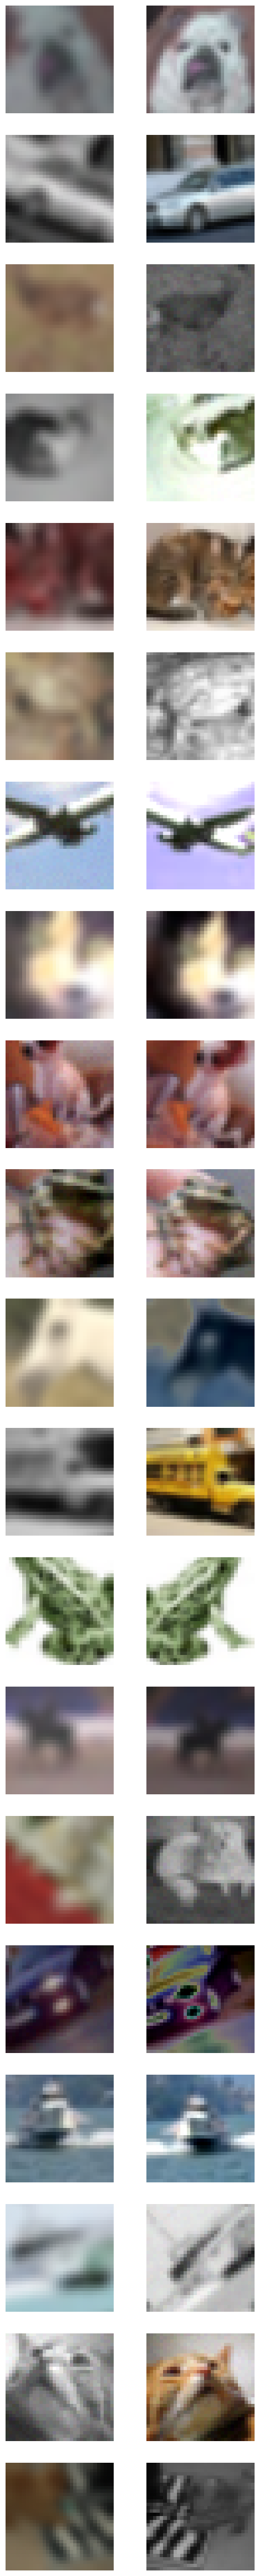

In [ ]:
show_bt_batch(dls=dls,n_in=n_in,aug=aug_pipelines,n=20,print_augs=True)

Step 4): Fit the learner:

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,56.933033,None,00:11


epoch,train_loss,valid_loss,time
0,2.283451,None,00:02


Step 5): Setup for linear evaluation:



In [ ]:
aug_pipelines_val=[get_linear_batch_augs(size=size,stats=cifar_stats,resize_scale=(0.3, 1.0))]
fastai_encoder.eval()
grad_on(fastai_encoder,on=False)
main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=1,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                        dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                        stats=cifar_stats,
                        aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                        encoder=fastai_encoder #encoder
                                   )
                            

Step 6): (optional): View validation augs (generally just cropping and normalization)

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: 


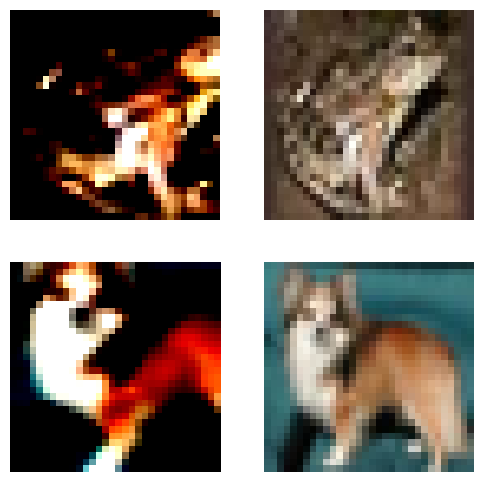

In [ ]:
show_linear_batch(dls=dls_val,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Step 7): (optional): View validation augs (generally just cropping and normalization)

In [ ]:
acc=main_linear_eval()
acc

epoch,train_loss,valid_loss,time
0,2.264807,None,00:04


/Users/hamishhaggerty/opt/anaconda3/envs/renamelater/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


0.12812499701976776

Here is how to use new p3:

In [ ]:
def lf_rbt(pred,seed,I,lmb):

    pred_enc = pred[0]
    pred = pred[1]
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    
    z1_enc, z2_enc = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / z1_enc.std(0, unbiased=False)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / z2_enc.std(0, unbiased=False)
    
    
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=10,indep=False,mask=True)
    cdiff_2 = CdiffSup(z1norm_enc,z2norm_enc) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=10,indep=True)
    cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

    cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2 #convex combination of rand and sup terms.

    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

#If we are using a different model, this call will just look like `create_rat_model(...)`
model = create_p3barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,62.104511,None,00:04
